In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from time import sleep, time
from random import randint
from IPython.core.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

In [159]:
def scraper(tot_page_num, pause_sec, start_site_string, is_clear_output=True):
    
    start_time = time()
    num_request = 0
    page_num = 1
    anime_num = 0

    anime_dataset_columns = ['anime', 'score', 'popularity',
                             'season_start', 'year_start', 'season_end', 'year_end',
                             'num_episodes', 'anime_type']
    anime_dataset = pd.DataFrame(columns=anime_dataset_columns)

    source = requests.get(start_site_string).text
    soup = BeautifulSoup(source, 'lxml')
    num_request += 1
    sleep(pause_sec)

    while True:

        for anime in soup.find_all('tr', class_='ranking-list'):

            # get information about the anime
            info_list = anime.find('div', class_='information di-ib mt4').text.strip().split()

            if len(info_list) == 10:

                # get the title of the anime
                anime_code = anime.find('a', class_='hoverinfo_trigger fl-l fs14 fw-b')
                anime_name = anime_code.text if anime_code is not None else np.nan

                # get the anime score
                score_code = anime.find('span', class_='text on')
                score = score_code.text if score_code is not None else np.nan

                anime_type = info_list[0]
                num_episodes = int(info_list[1].split('(')[-1].replace('?', '-500'))
                season_start, season_end = info_list[3], info_list[6]
                year_start, year_end = int(info_list[4]), int(info_list[7])
                popularity = int(info_list[-2].replace(',', ''))
                
                all_info_list = [anime_name, score, popularity,
                                 season_start, year_start, season_end, year_end,
                                 num_episodes, anime_type]
                info_dict = {column_name: info for column_name, info in zip(anime_dataset_columns, all_info_list)}
                anime_dataset = anime_dataset.append(info_dict, ignore_index=True)

            else:
                continue
        
        time_elapsed = time() - start_time
        print('processed {0:.3f} requests/s'.format(num_request/time_elapsed))

        print('{}/{} pages processed'.format(page_num, tot_page_num))
        
        if page_num == tot_page_num:
            print('terminated because total page specified reached')
            break

        # request the next page
        try: 
            next_code = soup.find('a', class_='link-blue-box next')
            source = requests.get(site_string + next_code['href']).text
            soup = BeautifulSoup(source, 'lxml')
    
        except: 
            print('terminated because no more pages can be accessed from the website')
            break

        num_request += 1
        sleep(pause_sec)

        # clear output
        if is_clear_output:
            clear_output(wait=True)

        page_num += 1
        
    return anime_dataset

In [160]:
tot_page_num = 400
pause_sec = 6

start_site_string = 'https://myanimelist.net/topanime.php'
anime_dataset = scraper(tot_page_num, pause_sec, start_site_string)

processed 0.123 requests/s
318/400 pages processed
terminated because no more pages can be accessed from the website


In [166]:
anime_dataset.to_csv('../anime_dataset.csv')

In [3]:
anime_dataset = pd.read_csv('../anime_dataset.csv')

In [7]:
anime_dataset.head()

,Unnamed: 0,anime,score,popularity,season_start,year_start,season_end,year_end,num_episodes,anime_type
0,0,Fullmetal Alchemist: Brotherhood,9.24,1476428,Apr,2009,Jul,2010,64,TV
1,1,Shingeki no Kyojin Season 3 Part 2,9.17,301513,Apr,2019,Jul,2019,10,TV
2,2,Steins;Gate,9.13,1229031,Apr,2011,Sep,2011,24,TV
3,3,Gintama°,9.12,256417,Apr,2015,Mar,2016,51,TV
4,4,Hunter x Hunter (2011),9.12,935814,Oct,2011,Sep,2014,148,TV


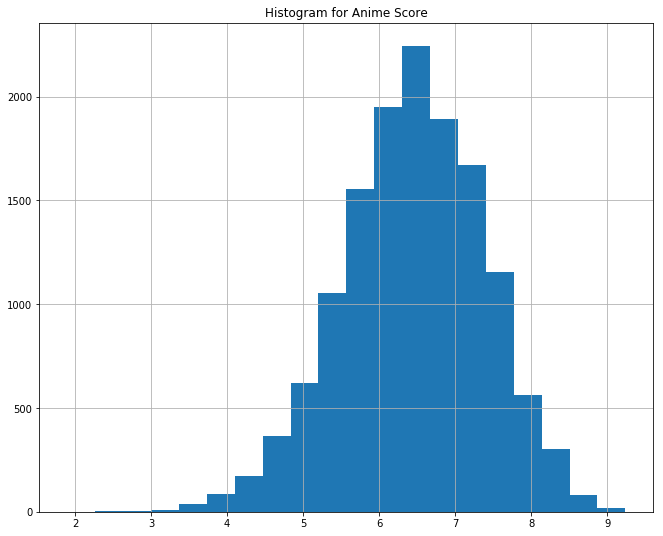

In [6]:
axis = anime_dataset.score.hist(bins=20, figsize=(11,9))
axis.set_title('Histogram for Anime Score')
plt.show()

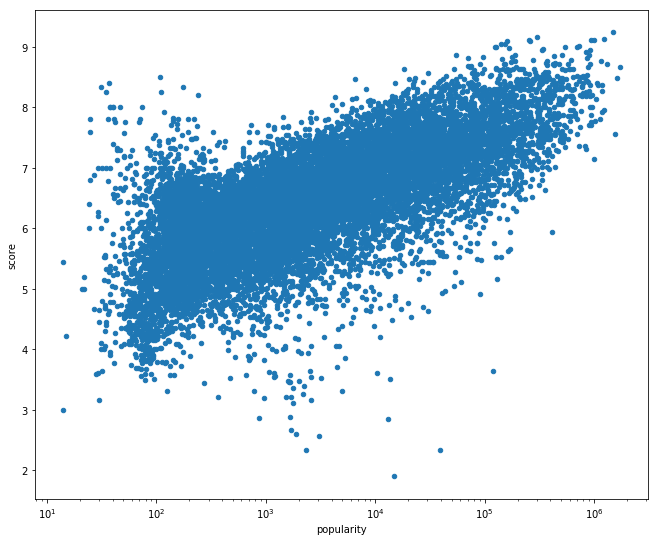

In [9]:
axis = anime_dataset.plot.scatter('popularity', 'score', figsize=(11,9), logx=True)
plt.show()